<a href="https://colab.research.google.com/github/young-hyun-park/training/blob/master/u_net_segmenatation%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import albumentations as A
import torch.nn.functional as F
import albumentations.pytorch
from torchvision import datasets, transforms
from torchsummary import summary
from PIL import Image
import os
import re
import cv2

In [2]:
seed = 1

lr = 0.001
momentum = 0.99

batch_size = 16
test_batch_size = 3

epochs = 100
log_interval = 100

In [3]:
path = '/content/drive/MyDrive/oxford_pet'
image_path =os.path.join(path+'/images')
mask_path = os.path.join(path+'/annotations/trimaps')

In [4]:
image_path_list = glob(image_path+'/*.jpg')

In [5]:
label_list = list()
for path in image_path_list:
    label_list.append(re.sub('_\d+','',path).split('/')[-1].split('.')[0])

In [6]:
df= pd.DataFrame(list(zip(image_path_list,label_list)),index = range(len(image_path_list)),columns = ['image_path','label'])

In [7]:
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size = 0.20, random_state = 42,stratify = df['label'])
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [8]:
train_df

,image_path,label
0,/content/drive/MyDrive/oxford_pet/images/yorks...,yorkshire_terrier
1,/content/drive/MyDrive/oxford_pet/images/havan...,havanese
2,/content/drive/MyDrive/oxford_pet/images/minia...,miniature_pinscher
3,/content/drive/MyDrive/oxford_pet/images/Birma...,Birman
4,/content/drive/MyDrive/oxford_pet/images/engli...,english_setter
...,...,...
5904,/content/drive/MyDrive/oxford_pet/images/minia...,miniature_pinscher
5905,/content/drive/MyDrive/oxford_pet/images/minia...,miniature_pinscher
5906,/content/drive/MyDrive/oxford_pet/images/Abyss...,Abyssinian
5907,/content/drive/MyDrive/oxford_pet/images/wheat...,wheaten_terrier


In [9]:
class Dataset(Dataset):
    def __init__(self, data_path,label,transform = None):
        self.data_path = data_path
        self.label = label
        self.transform = transform
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self,idx):
        path = self.data_path[idx]
        image = Image.open(path).convert('RGB')
        image = image.resize((256,256))
        image = np.array(image)
        image = image/255.0

        i_mask_path = os.path.splitext(path)[0].split('/')[-1]+'.png'        
        mask = Image.open(os.path.join(mask_path,i_mask_path))
        mask = mask.resize((256,256))
        mask = np.array(mask)
        mask[mask==2] = 0 #  0:Background 1: Foreground
        mask[mask >2] = 1 
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        image = image.transpose(2,0,1)
        mask = torch.as_tensor(mask.copy())
        image = torch.as_tensor(image.copy())
        sample = {'image':image, 'mask' : mask, 'path' : path}
        return sample
        

In [10]:
train_transform = A.Compose(
    [
             A.HorizontalFlip(p=0.5),
             A.VerticalFlip(p=0.5),
         A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
    ], p=0.8),
     


     ]
    )

In [11]:
train_image_path = train_df['image_path'].values
train_label = train_df['label'].values
test_image_path = test_df['image_path'].values
test_label = test_df['label'].values

In [12]:
train_data = Dataset(train_image_path,train_label,transform = train_transform)
test_data = Dataset(test_image_path,test_label)

In [13]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle = True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = batch_size,
    shuffle = False,
)

In [14]:
import torch
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(2).to(device)

In [16]:
summary(net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [17]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target))*2 + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p)) + self.smooth

        dice = num / den
        loss = 1 - dice
        return loss

class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

In [18]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [19]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas
            if clas ==0:
              iou_per_class.append(np.nan)
            elif true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [20]:
!nvidia-smi

Mon Oct  4 01:45:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    34W / 250W |   1635MiB / 16280MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
!ps aux | grep python

root          77  0.2  0.2 193892 60444 ?        Sl   01:38   0:01 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --MappingKernelManager.root_dir="/content"
root          90 10.2  9.5 14892804 2553948 ?    Ssl  01:44   0:08 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-eb4c1832-b6e1-45a6-b032-3793c26dadc6.json
root         112  0.3  0.0 128152 15608 ?        Sl   01:44   0:00 /usr/bin/python3 /usr/local/lib/python3.7/dist-packages/debugpy/adapter --for-server 41201 --host 127.0.0.1 --port 23763 --server-access-token 4d214151d74c13596b2170c21a00da8d197c26b666d1dcc00768c308a68eaf5a
root         271  0.0  0.0  18380  3104 ?        S    01:44   0:00 bash -c tail -n +0 -F "/root/.config/Google/DriveFS/Logs/drive_fs.txt" | python3 /opt/google/drive/drive-filter.py > "/root/.config/Google/DriveFS/Logs/timeouts.txt" 
root         273  0.0  0.0  31740  9640 ?        S    01:44   0:00 python3

In [22]:
!sudo kill -9 3035

kill: (3035): No such process


In [24]:
import time
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum= 0.9)
dice_loss= DiceLoss()
train_loss= list()
train_iou = list()
train_acc = list()
loss_val = list()
val_iou = list()
val_acc = list()
state = list()
PATH = '/content/drive/MyDrive/oxford_pet/check_points'
for epoch in range(1, epochs + 1):
    # Train Mode
    net.train()
    start  = time.time()
    iou = 0
    losses = 0
    train_acc_ = 0
    for batch_idx, data in enumerate(train_loader):
        inputs = data['image']
        inputs = inputs.to(device = device,dtype = torch.float32)
        masks = data['mask']
        labels = masks.to(device = device,dtype = torch.long)
        path = data['path']

        optimizer.zero_grad()
        masks_pred = net(inputs)
        loss = criterion(masks_pred,labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        iou += mIoU(masks_pred,labels)
        train_acc_ += pixel_accuracy(masks_pred, labels)
    print('\nTrain Epoch: {},Loss: {:.6f}, IOU: {:.4f}, Accuracy : {:0.3f},Time :{}'.format(
        epoch, losses/len(train_loader),iou/len(train_loader),train_acc_/len(train_loader),int(time.time()-start)))
    train_loss.append(losses/len(train_loader))
    train_iou.append(iou/len(train_loader))
    train_acc.append(train_acc_/len(train_loader))
    state.append(net.state_dict())
    torch.save({
          'model': net.state_dict(),
          'optimizer': optimizer.state_dict(),
          'epoch' : epoch
          }, PATH+'U-Net_seg_epoch{}_checkpoint'.format(epoch))

    
    # Test mode
    net.eval()
    val_loss = 0
    test_iou = 0
    val_acc_ = 0
    with torch.no_grad():
        for data in test_loader:
          inputs = data['image']
          inputs_test = inputs.to(device = device,dtype = torch.float32)
          masks = data['mask']
          labels_test = masks.to(device = device,dtype = torch.long)
          test_masks_pred = net(inputs_test)

          loss = criterion(test_masks_pred,labels_test)
          val_loss += loss.item() # sum up batch loss
          test_iou += mIoU(test_masks_pred,labels_test)
          val_acc_ +=  pixel_accuracy(test_masks_pred, labels_test)
    val_loss /= len(test_loader)
    loss_val.append(val_loss)
    val_iou.append(test_iou/len(test_loader))
    val_acc.append(val_acc_/len(test_loader))  

    print('Val set: Average loss: {:.4f}, IOU: {:.4f}, Accuracy : {:0.4f}'.format(val_loss,test_iou/len(test_loader),val_acc_/len(test_loader)))


Train Epoch: 1,Loss: 0.465078, IOU: 0.5890, Accuracy : 0.782,Time :2120
Val set: Average loss: 0.4034, IOU: 0.6594, Accuracy : 0.8199

Train Epoch: 2,Loss: 0.411442, IOU: 0.6390, Accuracy : 0.814,Time :272
Val set: Average loss: 0.4402, IOU: 0.6468, Accuracy : 0.8007

Train Epoch: 3,Loss: 0.389404, IOU: 0.6581, Accuracy : 0.826,Time :272
Val set: Average loss: 0.3453, IOU: 0.6979, Accuracy : 0.8495

Train Epoch: 4,Loss: 0.373376, IOU: 0.6723, Accuracy : 0.835,Time :272
Val set: Average loss: 0.3351, IOU: 0.6818, Accuracy : 0.8530

Train Epoch: 5,Loss: 0.361449, IOU: 0.6828, Accuracy : 0.841,Time :270
Val set: Average loss: 0.3221, IOU: 0.7005, Accuracy : 0.8620

Train Epoch: 6,Loss: 0.349404, IOU: 0.6939, Accuracy : 0.847,Time :271
Val set: Average loss: 0.3717, IOU: 0.6953, Accuracy : 0.8374

Train Epoch: 7,Loss: 0.341711, IOU: 0.7018, Accuracy : 0.852,Time :271
Val set: Average loss: 0.3139, IOU: 0.7171, Accuracy : 0.8657

Train Epoch: 8,Loss: 0.334275, IOU: 0.7095, Accuracy : 0.856

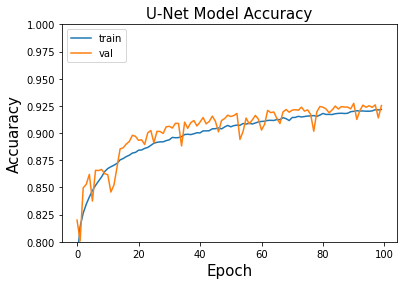

In [32]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('U-Net Model Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuaracy', fontsize = 15)
plt.ylim(0.8,1)
plt.legend(['train','val'], loc='upper left')
plt.show()

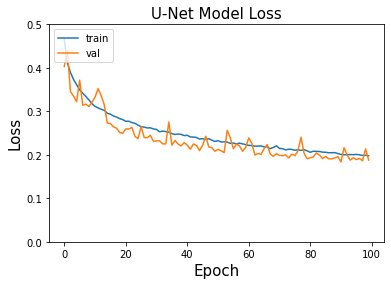

In [33]:
plt.plot(train_loss)
plt.plot(loss_val)
plt.title('U-Net Model Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.ylim(0,0.5)
plt.legend(['train','val'], loc='upper left')
plt.show()

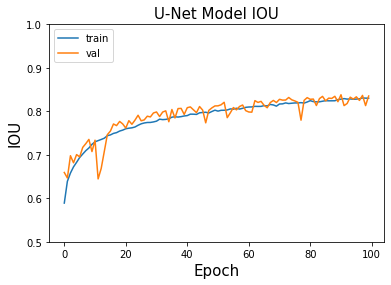

In [34]:
plt.plot(train_iou)
plt.plot(val_iou)
plt.title('U-Net Model IOU', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('IOU', fontsize = 15)
plt.ylim(0.5,1)
plt.legend(['train','val'], loc='upper left')
plt.show()

In [28]:
path = '/content/drive/MyDrive/oxford_pet/sixth_u-net_seg_model'

In [29]:
torch.save(net.state_dict(),path)

In [41]:
inputs.shape

torch.Size([6, 3, 256, 256])

In [42]:
labels.shape

torch.Size([5, 256, 256])

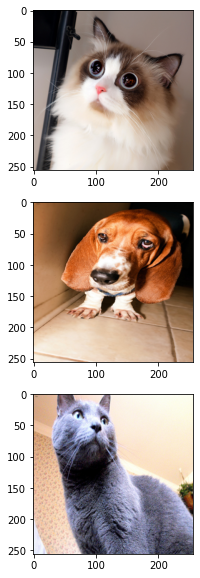

In [47]:
plt.figure(figsize = (10,10))
for i in range(3):  
  plt.subplot(3,1,i+1)
  plt.imshow(inputs[i].permute(1,2,0).cpu().data.numpy())

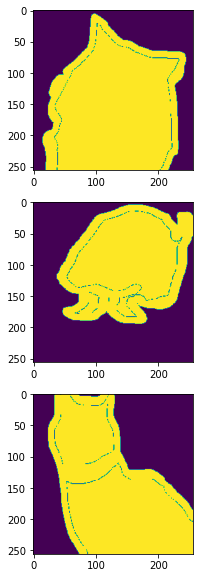

In [48]:
plt.figure(figsize = (10,10))
for i in range(3):  
  plt.subplot(3,1,i+1)
  plt.imshow(labels_test[i].cpu().data.numpy())

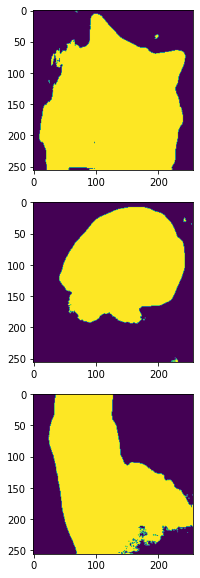

In [50]:
plt.figure(figsize = (10,10))
for i in range(3):  
  plt.subplot(3,1,i+1)
  plt.imshow(labels_test[i].cpu().data.numpy()) 
  plt.imshow(torch.argmax(F.softmax(test_masks_pred[i],dim = 0),dim = 0).cpu().data.numpy())

In [ ]:
type(torch.argmax(F.softmax(masks_pred[0],dim = 0),dim = 0))

In [ ]:
type(labels)

NameError: ignored

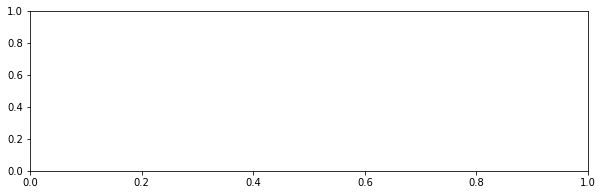

In [35]:
plt.figure(figsize = (10,10))
for i in range(3):  
  plt.subplot(3,1,i+1)
  plt.imshow(prediction[i].cpu().data.numpy())

In [ ]:
pred = F.softmax(masks_pred,dim = 1)
prediction = torch.argmax(pred,dim = 1)
prediction[0]

In [ ]:
state